# Datatype Fixes

## Reasoning

I have recently discovered that the default datatype that I have been using with Python/NumPy, namely Float (I think), has an insufficiently high max value. When that max is reached, the value of the number is set to `inf`. This will naturally break various calculations, and requires the data to be repaired where appropriate.


## Recourse

The reparation should be done as follows, more or less:

1. Determine which datatype is apprioriate **in Python**
2. Update the Python codebase to use the approriate datatype
3. Determine which datatype is appropriate **in SQL/PostgreSQL**
4. Migrate the database tables, where needed, to use the appropriate datatype
5. Determine which data is affected by the type error
    1. This might be all rows for certain benchmark functions (such as Schwefel 2.22) in sufficiently high dimensions
    2. And/or all rows that store values corresponding to the Python Float `inf` value; however, for the stored diversity and DRoC values, the fitness values are not stored, so this is not a powerful detection method
6. Delete the detected rows from the database
7. Re-run all data generation scripts to re-calculate the affected rows

## Considerations

It might be worth it to do the re-calculations on GCloud; this can become an expensive effort. However, the remote database has become out of sync with my local database due to previous reparations. Therefore it is important to also delete the rows corresponding to previously erroneous PSO algorithms; git can be used to determine which those were.


# 1. Which datatype is appropriate in Python?

According to [this](https://stackoverflow.com/a/3477332/1469018), the `long` type has unlimited precision.

We should be able to verify this by comparing the result of a function that produces `inf` with `float` types to that with `long` types:

In [21]:
import numpy as np

from psodroc.benchmarks import schwefel_2_22 as bench

# The Schwefel 2.22 function produces very large numbers in 1,000 dimensions.
D = 500
x = .5


xs = np.full(D, x)
fitness1 = bench.function(xs)
print 'with default datatype:', fitness1

xs = np.full(D, x, dtype=long)
fitness2 = bench.function(xs)
print 'with long:', fitness2

with default datatype: 250.0
with long: 0


Play around with x. Clearly, something is wrong:
1. With `x = 3.`, the results are the same (and very large)
2. With `x = 4.`, the float resulat is very large, but the long result is only 2000; this is clearly wrong.
3. With `x = .5`, the long result is `0`; long is an integer type!

Instead, let's try the _decimal_ type ([docs](https://docs.python.org/3/library/decimal.html#module-decimal)):

In [121]:
import numpy as np
from decimal import *

from psodroc.benchmarks import schwefel_2_22 as b

D = 1000
x = 9.

xs = np.full(D, x)
f1 = b.function(xs)
print 'float:', f1

# xs = np.full(D, x, dtype=Decimal)
xs = [Decimal(x) for x in xs]
f2 = b.function(xs)
print 'decimal:', f2

float: inf
decimal: 1.747871251722651609659974624E+954


Seems to work nicely. However, `dtype=Decimal` cannot be passed to numpy functions; numpy doesn't recognize the type. (Any version that seems to do that, actually just passes the values as `object`). Whether this approach ("casting" each element to a Decimal object) actually works the way it seems is not certain; see the answers and comments on [this post](https://stackoverflow.com/questions/7770870/numpy-array-with-dtype-decimal). 

Another often-suggested approach is to use _mpmath_ or (_SymPy_, which is built on _mpmath_).

Anyway, I do think _Decimal_ is the way to go; it will just require a lot of rewriting.

# 2. Update the Python codebase to use Decimal instead of float

## Which results are affected?

Could be only the ones where fitnesses go off the charts (incl Schwefel 2.22)

- Which would propogate those values to the PSOs solving them
- And also break the FLCs evaluating those fitnesses

So we could either (1) update those functions to convert their inputs to Decimal, or (2) update everything that uses those functions to convert their data to Decimal.

Considerations:

1. The functions would then return Decimal types, which may have adverse side-effects, requiring us to update the clients anyway
2. The functions cannot necessarily process Decimal input types (e.g. Weierstrass cannot), requiring us to update the functions anyway.

So seemingly, a hybrid approach is needed.

## Problematic benchmark functions

We can try and determine which benchmark functions (can) produce prolematic results by sampling various inputs and looking for `inf`, `-inf` or `nan`.

In [69]:
import math
import numpy as np

from results.benchmarks import all_names as all_benchmark_names
from results.benchmarks import get as get_benchmark

problematic_benchmark_names = set()
num_samples = 10000
D = 1

for benchmark_name in all_benchmark_names:
    print 'checking', benchmark_name, '...'
    benchmark = get_benchmark(benchmark_name)
    if not benchmark.is_dimensionality_valid(D):
        continue
        
    for _ in range(num_samples):
        xs = np.random.uniform(low=benchmark.min(0), high=benchmark.max(0), size=D)
        f = benchmark.function(xs)
        if math.isnan(f) or math.isinf(f):
            problematic_benchmark_names.add(benchmark_name)
            continue

print '\nAll problematic names:'
print problematic_benchmark_names

checking ackley ...
checking alpine ...
checking beale ...
checking bohachevsky1_generalized ...
checking eggholder ...
checking goldstein_price ...
checking griewank ...
checking levy13_generalized ...
checking michalewicz ...
checking pathological ...
checking quadric ...
checking quartic ...
checking rastrigin ...
checking rosenbrock ...
checking salomon ...
checking schwefel_2_22 ...
checking schwefel_2_26 ...
checking six_hump_camel_back ...
checking skew_rastrigin ...
checking spherical ...
checking step ...
checking weierstrass ...
checking zakharov ...

All problematic names:
set([])


In [70]:
%%html
<style>
table {float:left}
</style>

## Results:

Dimensions | Problematic functions
:---: | :---:
1000 | Schwefel 2.22
500 | Schwefel 2.22
100 etc | _None_ 


**So it's only Schwefel 2.22.**

So should we rather just convert to Decimal in the function body? We should just check what happens if the clients receive Decimal results.

(Updated) considerations:

1. Can PSO continue processing correctly?
2. Diversity doesn't take fitness into account, only position
3. Can **each of** the FLCs process Decimals?



## Can PSO process Decimals?

Let's create a Decimal-returning Schwefel 2.22 to test:

In [120]:
from decimal import *
import numpy as np

# Custom Decimal-returning version of Schwefel 2.22

def function_a(xs):
    """Use the default datatype (float)"""
    return np.sum(np.abs(xs)) + np.prod(np.abs(xs))

def function_b(xs):
    """Convert the input to Decimal"""
    xs = [Decimal(x) for x in xs]
    return np.sum(np.abs(xs)) + np.prod(np.abs(xs))

# Verify that the custom functon works.

xs = np.full(1000, 9)
print 'f:', function_b(xs)

f: 1.747871251722651609659974624E+954


Run one pso (gbest) on both and compare the results:

D: 5                          of 1000 ...  


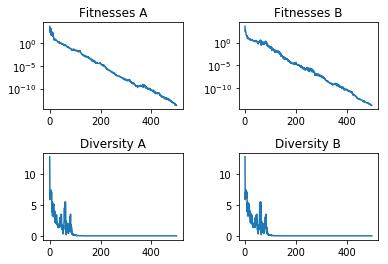

D: 50                                                                                                                                                                                     


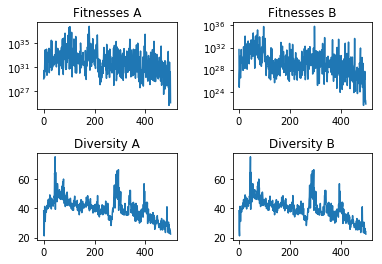

D: 500                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   


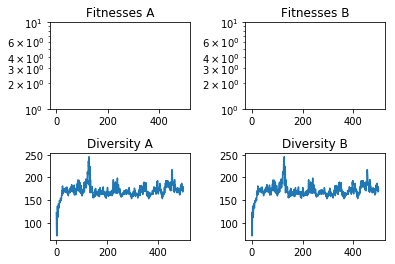

In [118]:
# Run previous cell first (the one that defines function_a and function_b)

from psodroc.pso import gbest_pso
from psodroc.measures import diversity
from matplotlib import pyplot as plt

lower = -10.
upper = 10.
swarm_size = 10
num_iterations = 500
Ds = [5, 50, 500]

for D in Ds:
    # Function A:
    gbest_pso.function = function_a
    gbest_pso.num_dimensions = D
    gbest_pso.lower_bound = lower
    gbest_pso.upper_bound = upper
    gbest_pso.init_pso_defaults()
    gbest_pso.init_swarm(size=swarm_size)
    fitnesses_a = []
    diversities_a = []
    for i in range(num_iterations):
        print '\r                ',
        print '\r', i+1, 'of', 2 * num_iterations, '...',
        f = np.mean(gbest_pso.fitnesses)
        fitnesses_a.append(f)
        d = diversity.avg_distance_around_swarm_centre(gbest_pso.positions)
        diversities_a.append(d)
        gbest_pso.iterate()
    
    # Function B:
    gbest_pso.function = function_b
    gbest_pso.num_dimensions = D
    gbest_pso.lower_bound = lower
    gbest_pso.upper_bound = upper
    gbest_pso.init_pso_defaults()
    gbest_pso.init_swarm(size=swarm_size)
    fitnesses_b = []
    diversities_b = []
    for i in range(num_iterations):
        print '\r                ',
        print '\r', i+1+num_iterations, 'of', 2*num_iterations, '...',
        f = np.mean(gbest_pso.fitnesses)
        fitnesses_b.append(f)
        d = diversity.avg_distance_around_swarm_centre(gbest_pso.positions)
        diversities_b.append(d)
        gbest_pso.iterate()
    
    # Plot
    print '\r                       \r',
    print 'D:', D
    
    f, axarr = plt.subplots(2, 2)
    # axarr is a [2, 2] array of subplots.
    # Use top row for fitnesses, bottom for diversities.
    # Use left for function A, right for function B.
    axarr[0][0].semilogy(fitnesses_a)
    axarr[0][0].set_title('Fitnesses A')
    axarr[0][1].semilogy(fitnesses_b)
    axarr[0][1].set_title('Fitnesses B')
    axarr[1][0].plot(diversities_b)
    axarr[1][0].set_title('Diversity A')
    axarr[1][1].plot(diversities_b)
    axarr[1][1].set_title('Diversity B')
    plt.subplots_adjust(wspace=0.4, hspace=0.5)
    plt.show()


While the results don't look promising in high dimensions, they *do* look basically identical between function A and B (where B returns the Decimal type); it looks like gbest PSO is fine with the alternative return type.

Note, though, that B processes significantly more slowly than A. Probably don't use Decimal unless needed.

Also note: The apparent same-ness between diversities obtained with functions A and B suggests that the strange high values might not affect diversity, and **might not warrant reparation**.

Next, let's look at other PSOs.

PSO: alternative_barebones_pso
D: 5
D: 5                     A 192 


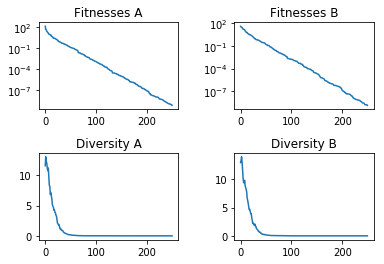

D: 40
D: 40                  


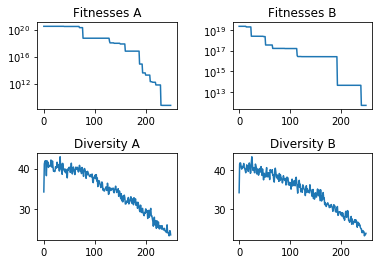

D: 400
D: 400                   


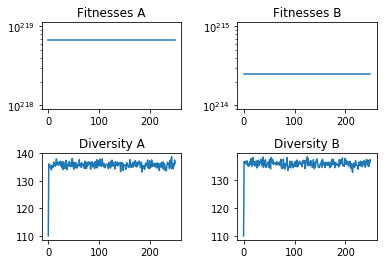

PSO: barebones_pso
D: 5
D: 5                    49 162  80 


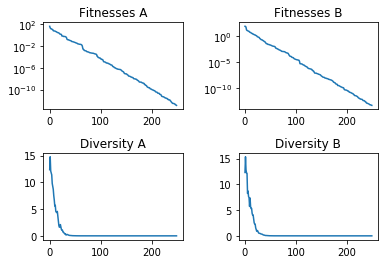

D: 40
D: 40                  


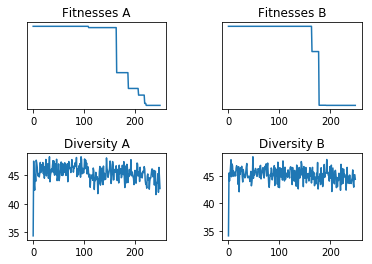

D: 400
D: 400                 A 28 


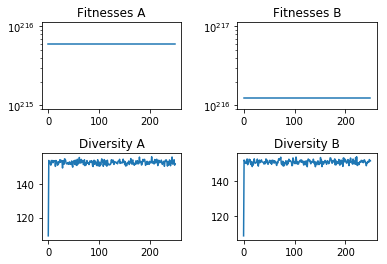

PSO: gbest_pso
D: 5


In [ ]:
# Run cell 2 cells above (the one that defines function_a and function_b)
import sys

from results import psos
from psodroc.measures import diversity
from matplotlib import pyplot as plt

lower = -10.
upper = 10.
swarm_size = 10
num_iterations = 250
pso_names = psos.all_names
Ds = [5, 40, 400]
num_samples = 5

for pso_name in pso_names:
    print 'PSO:', pso_name
    pso = psos.get(pso_name)
    
    for D in Ds:
        print 'D:', D
        
        all_fitnesses_a = []
        all_fitnesses_b = []
        all_diversities_a = []
        all_diversities_b = []
        
        for s in range(num_samples):
        
            # Function A:
            pso.function = function_a
            pso.num_dimensions = D
            pso.lower_bound = lower
            pso.upper_bound = upper
            pso.init_pso_defaults()
            pso.init_swarm(size=swarm_size)
            fitnesses_a = []
            diversities_a = []
            for i in range(num_iterations):
#                 print '                                \r',
#                 print (i+1)+(s*num_iterations), '/', 2*num_iterations*num_samples, '...\r',
                print '', s, 'A', i+1, '\r',
                f = pso.gbest_fitness
                fitnesses_a.append(f)
                d = diversity.avg_distance_around_swarm_centre(pso.positions)
                diversities_a.append(d)
                pso.iterate()
            all_fitnesses_a.append(fitnesses_a)
            all_diversities_a.append(diversities_a)

            # Function B:
            pso.function = function_b
            pso.num_dimensions = D
            pso.lower_bound = lower
            pso.upper_bound = upper
            pso.init_pso_defaults()
            pso.init_swarm(size=swarm_size)
            fitnesses_b = []
            diversities_b = []
            for i in range(num_iterations):
#                 print '                                \r',
#                 print (i+1+num_iterations)*(s*num_iterations), 'of', 2*num_iterations*num_samples, '...',
                print '', s, 'B', i+1, '\r',
                f = pso.gbest_fitness
                fitnesses_b.append(f)
                d = diversity.avg_distance_around_swarm_centre(pso.positions)
                diversities_b.append(d)
                pso.iterate()
            all_fitnesses_b.append(fitnesses_b)
            all_diversities_b.append(diversities_b)
            

        # Plot
        print '\r                       \r',
        print 'D:', D
        
        # Take means of the data
        fitnesses_a = np.mean(all_fitnesses_a, axis=0)
        fitnesses_b = np.mean(all_fitnesses_b, axis=0)
        diversities_a = np.mean(all_diversities_a, axis=0)
        diversities_b = np.mean(all_diversities_b, axis=0)

        # Plot as nice grouped subplots for side-by-side comparison
        f, axarr = plt.subplots(2, 2)
        # axarr is a [2, 2] array of subplots.
        # Use top row for fitnesses, bottom for diversities.
        # Use left for function A, right for function B.
        axarr[0][0].semilogy(fitnesses_a)
        axarr[0][0].set_title('Fitnesses A')
        axarr[0][1].semilogy(fitnesses_b)
        axarr[0][1].set_title('Fitnesses B')
        axarr[1][0].plot(diversities_a)
        axarr[1][0].set_title('Diversity A')
        axarr[1][1].plot(diversities_b)
        axarr[1][1].set_title('Diversity B')
        plt.subplots_adjust(wspace=0.4, hspace=0.5)
        plt.show()

    




~~**So** (unless the remaining results that are currently running paint a different picture):~~

~~The diversity results are _not_ affected by the datatype issue, and we do not have to re-run any PSOs.~~

~~So we don't (necessarily) need to make any changes to the database either (unless there are tables that store results that inherit their large-ness from the fitnesses of the Schwefel 2.22 function, which I don't think there are).~~

I had a bug; let's try again

# 3. Which datatype is appropriate in PostgreSQL?

It's `numeric`.

But: 

1. We don't really store large values in the DB; the issue seems to arise from large fitness values, which are not stored, and the results that were calculated using those fitness values, which are typically normalized to [0,1]. (Except maybe the DRoC values, for which there are some quite small values (around -700), which is well within precision, but might be indicative of invalid fitness values?)
2. If we do need very large values (or very close-to-zero ones), I believe we will have to specify the precision, so we need to determine how big is big enough.